In [ ]:
#

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

ModuleNotFoundError: No module named 'pandas'

In [ ]:
import argparse
import cv2
import numpy as np
import os

class YOLOPv2():
    def __init__(self, model_path, confThreshold=0.5):
        self.classes = list(map(lambda x: x.strip(), open('coco.names', 'r').readlines()))
        self.num_class = len(self.classes)
        self.net = cv2.dnn.readNet(model_path)
        filename = os.path.splitext(os.path.basename(model_path))[0]
        if 'Nx3x' not in filename:
            input_shape = filename.split('_')[-1].split('x')
        else:
            input_shape = filename.split('Nx3x')[-1].split('_')[-1].split('x')
        self.input_height = int(input_shape[0])
        self.input_width = int(input_shape[1])
        self.output_names = self.net.getUnconnectedOutLayersNames()
        self.confThreshold = confThreshold
        self.nmsThreshold = 0.5
        anchors = [[12, 16, 19, 36, 40, 28], [36, 75, 76, 55, 72, 146], [142, 110, 192, 243, 459, 401]]
        self.na = len(anchors[0]) // 2
        self.no = len(self.classes) + 5
        self.stride = [8, 16, 32]
        self.nl = len(self.stride)
        self.anchors = np.asarray(anchors, dtype=np.float32).reshape(3, 3, 1, 1, 2)
        self.generate_grid()

    def generate_grid(self):
        self.grid = []
        for i in range(self.nl):
            h, w = int(self.input_height / self.stride[i]), int(self.input_width / self.stride[i])
            self.grid.append(self._make_grid(w, h))
    def _make_grid(self, nx=20, ny=20):
        xv, yv = np.meshgrid(np.arange(nx), np.arange(ny))
        return np.stack((xv, yv), 2).reshape(1, 1, ny, nx, 2).astype(np.float32)

    def drawPred(self, frame, classId, conf, left, top, right, bottom):
        # Draw a bounding box.
        cv2.rectangle(frame, (left, top), (right, bottom), (0, 0, 255), thickness=2)

        label = '%.2f' % conf
        label = '%s:%s' % (self.classes[classId - 1], label)

        # Display the label at the top of the bounding box
        labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
        top = max(top, labelSize[1])
        # cv.rectangle(frame, (left, top - round(1.5 * labelSize[1])), (left + round(1.5 * labelSize[0]), top + baseLine), (255,255,255), cv.FILLED)
        cv2.putText(frame, label, (left, top - 10), 0, 0.7, (0, 255, 0), thickness=2)
        return frame
    def detect(self, frame):
        image_width, image_height = frame.shape[1], frame.shape[0]
        ratioh = image_height / self.input_height
        ratiow = image_width / self.input_width

        blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (self.input_width, self.input_height), [0, 0, 0], swapRB=True,
                                     crop=False)
        # Perform inference on the image
        self.net.setInput(blob)
        # Runs the forward pass to get output of the output layers
        results = self.net.forward(self.output_names)

        z = []
        for i in range(3):
            bs, _, ny, nx = results[i*2].shape
            y = results[i*2].reshape(bs, 3, 5+self.num_class, ny, nx).transpose(0, 1, 3, 4, 2)
            y = 1 / (1 + np.exp(-y))
            y[..., 0:2] = (y[..., 0:2] * 2. - 0.5 + self.grid[i]) * self.stride[i]  # xy
            y[..., 2:4] = (y[..., 2:4] * 2) ** 2 * self.anchors[i]  # wh
            z.append(y.reshape(bs, -1, 5+self.num_class))
        det_out = np.concatenate(z, axis=1).squeeze(axis=0)

        boxes, confidences, classIds = [], [], []
        for i in range(det_out.shape[0]):
            # if det_out[i, 4] < self.confThreshold:
            #     continue

            if det_out[i, 4] * np.max(det_out[i, 5:]) < self.confThreshold:
                continue

            class_id = np.argmax(det_out[i, 5:])
            cx, cy, w, h = det_out[i, :4]
            x = int((cx - 0.5*w) * ratiow)
            y = int((cy - 0.5*h) * ratioh)
            width = int(w * ratiow)
            height = int(h* ratioh)

            boxes.append([x, y, width, height])
            classIds.append(class_id)
            confidences.append(det_out[i, 4] * np.max(det_out[i, 5:]))
        indices = cv2.dnn.NMSBoxes(boxes, confidences, self.confThreshold, self.nmsThreshold)
        for i in indices:
            box = boxes[i]
            left = box[0]
            top = box[1]
            width = box[2]
            height = box[3]
            frame = self.drawPred(frame, classIds[i], confidences[i], left, top, left + width, top + height)

        # Drivable Area Segmentation
        drivable_area = np.squeeze(results[1], axis=0)
        mask = np.argmax(drivable_area, axis=0).astype(np.uint8)
        mask = cv2.resize(mask, (image_width, image_height), interpolation=cv2.INTER_NEAREST)
        frame[mask==1] = [0, 255, 0]
        # Lane Line
        lane_line = np.squeeze(results[3])
        mask = np.where(lane_line > 0.5, 1, 0).astype(np.uint8)
        mask = cv2.resize(mask, (image_width, image_height), interpolation=cv2.INTER_NEAREST)
        frame[mask==1] = [255, 0, 0]
        return frame

In [11]:
import sys

In [4]:
!{sys.executable} -m pip install scikit-image

     ---------------------------------------- 0.0/23.7 MB ? eta -:--:--
     - -------------------------------------- 0.7/23.7 MB 21.8 MB/s eta 0:00:02
     --- ------------------------------------ 2.2/23.7 MB 27.4 MB/s eta 0:00:01
     ---- ----------------------------------- 2.5/23.7 MB 22.8 MB/s eta 0:00:01
     ----- ---------------------------------- 3.3/23.7 MB 19.1 MB/s eta 0:00:02
     ------ --------------------------------- 3.8/23.7 MB 17.3 MB/s eta 0:00:02
     ------- -------------------------------- 4.2/23.7 MB 15.7 MB/s eta 0:00:02
     ------- -------------------------------- 4.5/23.7 MB 14.3 MB/s eta 0:00:02
     -------- ------------------------------- 4.8/23.7 MB 13.2 MB/s eta 0:00:02
     -------- ------------------------------- 5.1/23.7 MB 12.4 MB/s eta 0:00:02
     --------- ------------------------------ 5.4/23.7 MB 11.9 MB/s eta 0:00:02
     --------- ------------------------------ 5.7/23.7 MB 11.4 MB/s eta 0:00:02
     ---------- ----------------------------- 6.

In [31]:
!{sys.executable} -m pip install  torch

ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


ERROR: Could not find a version that satisfies the requirement package (from versions: none)
ERROR: No matching distribution found for package
ERROR: Could not find a version that satisfies the requirement torch (from versions: none)
ERROR: No matching distribution found for torch


In [47]:
!{sys.executable} -m pip install "C:\Users\omhot\Downloads\pytorch-master"

Processing c:\users\omhot\downloads\pytorch-master
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'error'


  error: subprocess-exited-with-error
  
  × Preparing metadata (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [8 lines of output]
      fatal: not a git repository (or any of the parent directories): .git
      -- Building version 2.1.0a0+gitUnknown
       --- Trying to initialize submodules
      fatal: not a git repository (or any of the parent directories): .git
       --- Submodule initalization failed
      Please run:
          git submodule update --init --recursive
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [30]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans 
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as keras
input_size = (256,256,1)
inputs = Input(input_size)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
drop4 = Dropout(0.5)(conv4)
pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
drop5 = Dropout(0.5)(conv5)
up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
merge6 = concatenate([drop4,up6], axis = 3)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)
up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
merge7 = concatenate([conv3,up7], axis = 3)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)
up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
merge8 = concatenate([conv2,up8], axis = 3)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)
up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
merge9 = concatenate([conv1,up9], axis = 3)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)
model = Model( inputs,conv10)
model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.save(filepath="../Final/Unet.hdf5")
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  640         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

In [25]:
unet()

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_299 (Conv2D)            (None, 256, 256, 64  640         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_300 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_299[0][0]']             
                                )                                                          

In [10]:
import sys

In [35]:
!{sys.executable} -m pip install scikit-learn --user

     ---------------------------------------- 0.0/8.2 MB ? eta -:--:--
     -- ------------------------------------- 0.5/8.2 MB 10.5 MB/s eta 0:00:01
     ------- -------------------------------- 1.5/8.2 MB 19.7 MB/s eta 0:00:01
     ------------- -------------------------- 2.8/8.2 MB 22.4 MB/s eta 0:00:01
     ---------------- ----------------------- 3.3/8.2 MB 17.7 MB/s eta 0:00:01
     ------------------- -------------------- 4.0/8.2 MB 17.1 MB/s eta 0:00:01
     --------------------- ------------------ 4.4/8.2 MB 16.4 MB/s eta 0:00:01
     ---------------------- ----------------- 4.6/8.2 MB 14.8 MB/s eta 0:00:01
     ----------------------- ---------------- 4.8/8.2 MB 13.4 MB/s eta 0:00:01
     ------------------------ --------------- 5.1/8.2 MB 12.4 MB/s eta 0:00:01
     ------------------------- -------------- 5.3/8.2 MB 11.7 MB/s eta 0:00:01
     -------------------------- ------------- 5.5/8.2 MB 11.1 MB/s eta 0:00:01
     ---------------------------- ----------- 5.8/8.2 MB 10.

In [12]:
import netron

In [18]:
netron.start(model)

TypeError: stat: path should be string, bytes, os.PathLike or integer, not Functional

In [5]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt



DIR = "D:/Data/driver_161_90frame/06030819_0755.MP4/"
img = plt.imread(DIR+"00000.jpg")
plt.figure(figsize=(16,18))
plt.imshow(img)

FileNotFoundError: [Errno 2] No such file or directory: 'D:/Data/driver_161_90frame/06030819_0755.MP4/00000.jpg'

# Bew

In [1]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from os import walk
import cv2

In [2]:
img_file = "D:/Data/driver_182_30frame/05312336_0004.MP4/00000.jpg"
text_file = "../Data/driver_182_30frame/05312336_0004.MP4/00000.lines.txt"

def remove_newlines(fname):
    data=[]
    coordinates =[]
    flist = open(fname).readlines()
    for s in flist:
        data.extend([d for d in s.rstrip('\n').split(" ")  if d!=''])  #to remove newline and split at whitespace
     
    data = np.array(data).astype(np.float32) 
        
    for idx in range(0,len(data),2):
        coordinates.append(data[idx:idx+2])
    if(len(data)==0):
        return None , None  , 0 , 0
    
    else:

        mean_val = np.mean(data)
        std_val = np.std(data)
        return coordinates , data , mean_val  , std_val

In [49]:
img_files = []
label_data=[]
mean_array=[]
std_array = []
coordinate_list=[]
for dirpath, dirnames, filenames in walk("D:/Data/driver_182_30frame"):
    for files in filenames :
        if(files.split(".")[-1]=="jpg"):
            txt_file = os.path.join(dirpath , files.split(".")[0]+str(".lines.txt") )
            coordinates , data , mean_val , std_val  = remove_newlines(txt_file)
            if(data is not None):
                img_files.append(os.path.join(dirpath,files))
                label_data.append( data )
                mean_array.append(mean_val)
                std_array.append(std_val)
                coordinate_list.append(coordinates)

In [58]:
g=cv2.imread(img_files[1])
cv2.imshow("", g)
cv2.waitKey(0)
cv2.destroyAllWindows()

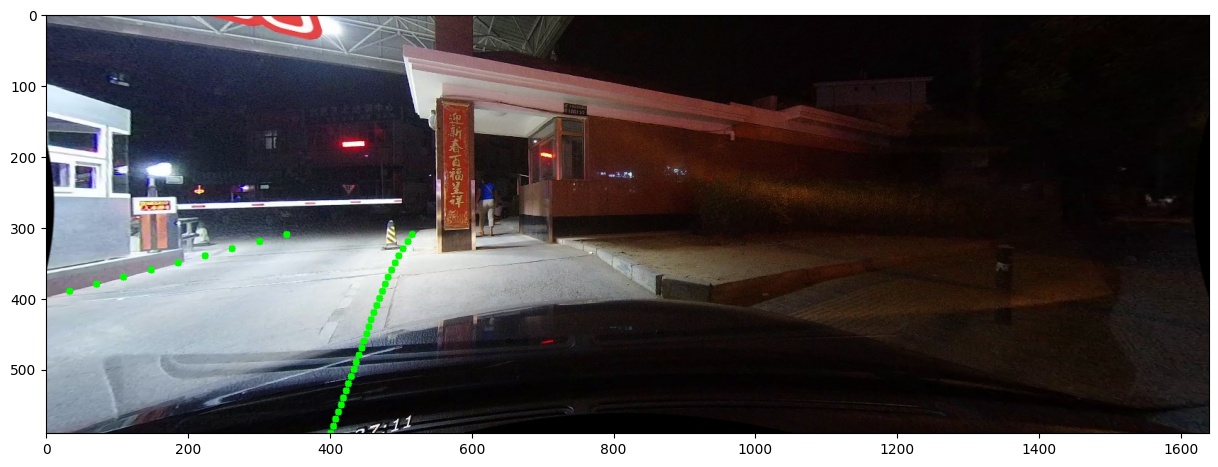

In [5]:
#from dataHandler
fig = plt.figure(figsize=(15,10))
def plot_data (image_file , coordinates):
    img = cv2.imread(image_file)
    img_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
    for x , y in coordinates :
        cv2.circle(img_rgb,(int(float(x)), int(float(y)) ) , 5, (0,255,0), -1)
    plt.imshow(img_rgb)
    plt.show()
plot_data(img_files[0] , coordinate_list[0])

# __________________________________________________________________________________________________________________

In [39]:
root = "driver_182_30frame"
rpath = "D:/Data/driver_182_30frame/"

In [37]:
import os
results=[]
with open("D:/Data/list/train_gt.txt","r") as f:
    for line in f :
        #line = line.strip()
        data = line.split(" ")
        set1 = data[0].split("/")[1:]
        if(set1[0] == "driver_182_30frame"):
            results.append(data)

In [75]:
results

[['/driver_182_30frame/05312327_0001.MP4/00000.jpg',
  '/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00000.png',
  '0',
  '1',
  '1',
  '0\n'],
 ['/driver_182_30frame/05312327_0001.MP4/00030.jpg',
  '/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00030.png',
  '0',
  '1',
  '1',
  '0\n'],
 ['/driver_182_30frame/05312327_0001.MP4/00060.jpg',
  '/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00060.png',
  '0',
  '1',
  '1',
  '0\n'],
 ['/driver_182_30frame/05312327_0001.MP4/00090.jpg',
  '/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00090.png',
  '0',
  '1',
  '1',
  '0\n'],
 ['/driver_182_30frame/05312327_0001.MP4/00120.jpg',
  '/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00120.png',
  '0',
  '1',
  '1',
  '0\n'],
 ['/driver_182_30frame/05312327_0001.MP4/00150.jpg',
  '/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00150.png',
  '0',
  '1',
  '1',
  '0\n'],
 ['/driver_182_30frame/05312327_0001.MP4/00180.jpg',
  '/laneseg_label

works till here

In [74]:
results.sort()

In [73]:
t1

['', 'driver_182_30frame', '05312327_0001.MP4', '00030.jpg']

In [68]:
os.path.join("D:/Data",t1[0],t1[1],t1[2])

'D:/Data\\driver_182_30frame\\06011143_0165.MP4'

In [76]:
import cv2
data_set=[]
for data in results :
    exist=[int(x) for x in data[2:]]
    label_sep = data[1].split("/")
    img_path= "D:/Data"+data[0]
    label_path = "D:/Data"+data[1]
    dict_culane={
        "img_path":img_path ,
        "label_path":label_path ,
        "exist":exist 
    }
    data_set.append(dict_culane)

In [82]:
import sys
!{sys.executable} -m pip install torch
import torchnn as nn

ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python setup.py install && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python setup.py develop && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [83]:
sys.version

'3.11.2 (tags/v3.11.2:878ead1, Feb  7 2023, 16:38:35) [MSC v.1934 64 bit (AMD64)]'

In [81]:
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data import SubsetRandomSampler
import numpy as np
class CreateDataSet(Dataset):
    def __init__(self,data_set , seed):
        self.data_set = data_set
        self.seed = torch.manual_seed(seed)
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((288,800)) ,
            transforms.ToTensor(),
            transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225] )
        ])
        self.transform_label = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((288,800)) ,
        ])
        self.transform_exist = transforms.Compose([
            transforms.ToTensor()
        ])
    def __len__(self):
        return len(self.data_set)
    
    def __getitem__(self,index):
        data_item = self.data_set[index]
        #read the image data
        img = cv2.imread(data_item["img_path"])
        img_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
        img_rgb = self.transform(img_rgb)
        #read the label image
        label = cv2.imread(data_item["label_path"])[:,:,0]
        label = np.array(self.transform_label(label))
        if(len(data_item["exist"]) ==4 and label is not None):
            exists = np.array(data_item["exist"])
            
        else:
            exists = None
        exists = torch.from_numpy(exists)
        sample = {
            "data":img_rgb ,
            "target":label , 
            "exist":exists
        }
        
        return sample
train_data = CreateDataSet(data_set , 0)

size_train = len(train_data)
idx_list = list(range(size_train))
np.random.seed(0)
np.random.shuffle(idx_list)
train_val_split = 0.2
split_index = int(size_train * train_val_split)

#take the appropriate index values for train and val
train_idx = idx_list[split_index :]
val_idx = idx_list[:split_index]

train_sampler = SubsetRandomSampler(train_idx)
validate_sampler = SubsetRandomSampler(val_idx)

train_loader = DataLoader(train_data ,sampler=train_sampler , batch_size=16 )
valid_loader = DataLoader(train_data , sampler=validate_sampler , batch_size=16)

ImportError: Failed to load PyTorch C extensions:
    It appears that PyTorch has loaded the `torch/_C` folder
    of the PyTorch repository rather than the C extensions which
    are expected in the `torch._C` namespace. This can occur when
    using the `install` workflow. e.g.
        $ python setup.py install && python -c "import torch"

    This error can generally be solved using the `develop` workflow
        $ python setup.py develop && python -c "import torch"  # This should succeed
    or by running Python from a different directory.

In [78]:
data_set[2]

{'img_path': 'D:/Data/driver_182_30frame/05312327_0001.MP4/00060.jpg',
 'label_path': 'D:/Data/laneseg_label_w16/driver_182_30frame/05312327_0001.MP4/00060.png',
 'exist': [0, 1, 1, 0]}

In [31]:
import sys
sys.path

['g:\\New folder\\PBL\\Final',
 'e:\\Python-main\\python311.zip',
 'e:\\Python-main\\DLLs',
 'e:\\Python-main\\Lib',
 'e:\\Python-main',
 '',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin',
 'e:\\Python-main\\Lib\\site-packages']

In [34]:
sys.path.insert(0,r"e:\andaconda\lib\site-packages")

In [35]:
sys.path

['e:\\andaconda\\lib\\site-packages',
 'e:\x07ndaconda\\lib\\site-packages',
 'g:\\New folder\\PBL\\Final',
 'e:\\Python-main\\python311.zip',
 'e:\\Python-main\\DLLs',
 'e:\\Python-main\\Lib',
 'e:\\Python-main',
 '',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages\\win32\\lib',
 'C:\\Users\\omhot\\AppData\\Roaming\\Python\\Python311\\site-packages\\Pythonwin',
 'e:\\Python-main\\Lib\\site-packages']

In [ ]:
!{sys.executable} -m pip install torch 

In [62]:
def transform_label(label):
    label = tf.image.convert_image_dtype(label, dtype=tf.uint8)  # convert to PIL image format
    label = tf.image.resize(label, size=(288, 800))  # resize label to desired size
    return label

In [3]:
import tensorflow as tf
import numpy as np
import cv2

class CreateDataSet(tf.keras.utils.Sequence):
    def __init__(self, data_set, seed, batch_size=16):
        self.data_set = data_set
        self.seed = seed
        self.batch_size = batch_size
        self.transform = tf.keras.Sequential([
            tf.keras.layers.Lambda(lambda x: tf.image.convert_image_dtype(x, dtype=tf.float32)),
            tf.keras.layers.Lambda(lambda x: tf.image.resize(x, (288, 800))),
            tf.keras.layers.Lambda(lambda x: tf.keras.applications.mobilenet_v2.preprocess_input(x))
        ])
        
    def __len__(self):
        return int(np.ceil(len(self.data_set) / float(self.batch_size)))
    
    def __getitem__(self, index):
        batch = self.data_set[index*self.batch_size:(index+1)*self.batch_size]
        images = []
        labels = []
        exists_list = []
        
        for data_item in batch:
            #read the image data
            img = cv2.imread(data_item["img_path"])
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_rgb = self.transform(img_rgb)
            
            #read the label image
            label = cv2.imread(data_item["label_path"])[:,:,0]
            label = cv2.resize(label, (800, 288), interpolation=cv2.INTER_NEAREST)
            
            if(len(data_item["exist"]) == 4 and label is not None):
                exists = np.array(data_item["exist"])
            else:
                exists = None
            exists_list.append(exists)
            images.append(img_rgb)
            labels.append(label)
        
        exists = tf.convert_to_tensor(exists_list)
        images = tf.convert_to_tensor(images)
        labels = tf.convert_to_tensor(labels)
        
        return {"data": images, "target": labels, "exist": exists}

In [ ]:
import cv2
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical

data_set=[]
for data in results :
    exist=[int(x) for x in data[2:]]
    img_sep = data[0].split(os.path.sep)
    label_sep = data[1].split(os.path.sep)
    label_path = os.path.join("../input/culane/driver_161_90frame_labels" , label_sep[-2], label_sep[-1])
    img_path= os.path.join("../input/culane", img_sep[1] , img_sep[2] , img_sep[3])
    dict_culane={
        "img_path":img_path ,
        "label_path":label_path ,
        "exist":exist 
    }
    data_set.append(dict_culane)

class CreateDataSet(tf.keras.utils.Sequence):
    def __init__(self, data_set, batch_size=16):
        self.data_set = data_set
        self.batch_size = batch_size
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.data_set) / self.batch_size))

    def __getitem__(self, index):
        batch = self.data_set[index * self.batch_size:(index + 1) * self.batch_size]
        data = []
        labels = []
        exists = []
        for sample in batch:
            #read the image data
            img = cv2.imread(sample["img_path"])
            img_rgb = cv2.cvtColor(img , cv2.COLOR_BGR2RGB)
            img_rgb = self.transform(img_rgb)
            #read the label image
            label = cv2.imread(sample["label_path"])[:,:,0]
            label = np.array(self.transform_label(label))
            if(len(sample["exist"]) == 4 and label is not None):
                exists.append(sample["exist"])
            else:
                exists.append(None)

            data.append(img_rgb)
            labels.append(label)
        
        data = tf.convert_to_tensor(np.array(data))
        labels = tf.convert_to_tensor(np.array(labels))
        exists = tf.convert_to_tensor(np.array(exists))
        exists = tf.squeeze(exists)
        exists = to_categorical(exists, num_classes=2)

        return {"data":data, "target":labels, "exist":exists}

    def on_epoch_end(self):
        np.random.shuffle(self.data_set)

train_data = CreateDataSet(data_set)

size_train = len(train_data)
idx_list = list(range(size_train))
np.random.seed(0)
np.random.shuffle(idx_list)
train_val_split = 0.2
split_index = int(size_train * train_val_split)

#take the appropriate index values for train and val
train_idx = idx_list[split_index :]
val_idx = idx_list[:split_index]

train_loader = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_types={"data": tf.float32, "target": tf.float32, "exist": tf.float32},
    output_shapes={"data": tf.TensorShape([None, 288, 800, 3]), "target": tf.TensorShape([None, 288, 800, 1]), "exist": tf.TensorShape([None, 2])}
).shuffle(buffer_size=1024).batch(16)

valid_loader = tf.data.Dataset.from_generator(
    lambda: train_data,
    output_types={"data": tf.float32, "target": tf.float32, "exist": tf.float32},
    output_shapes={"data": tf.TensorShape([None, 288, 800, 3]), "target": tf.TensorShape([None, 288, 800,


In [79]:
import tensorflow as tf
import numpy as np
import cv2

class CreateDataSet(tf.keras.utils.Sequence):
    def __init__(self, data_set, batch_size, seed):
        self.data_set = data_set
        self.batch_size = batch_size
        self.seed = seed
        self.transform = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Resizing(288, 800),
            tf.keras.layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225])
        ])
        self.transform_label = tf.keras.Sequential([
            tf.keras.layers.experimental.preprocessing.Resizing(288, 800)
        ])
        self.transform_exist = None

    def __len__(self):
        return int(np.ceil(len(self.data_set) / self.batch_size))

    def __getitem__(self, index):
        batch_data = self.data_set[index * self.batch_size:(index + 1) * self.batch_size]
        data = []
        target = []
        exist = []
        for data_item in batch_data:
            # read the image data
            img = cv2.imread(data_item["img_path"])
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_rgb = self.transform(img_rgb)
            data.append(img_rgb)
            # read the label image
            label = cv2.imread(data_item["label_path"])[:, :, 0]
            label = np.array(self.transform_label(label))
            target.append(label)
            if len(data_item["exist"]) == 4 and label is not None:
                exists = np.array(data_item["exist"])
            else:
                exists = None
            exist.append(exists)
        data = tf.convert_to_tensor(data)
        target = tf.convert_to_tensor(target)
        if self.transform_exist is not None:
            exist = tf.convert_to_tensor(exist)
        return {"data": data, "target": target, "exist": exist}



In [80]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import ImageDataGenerator


class CreateDataSet(Sequence):
    def __init__(self, data_set, batch_size):
        self.data_set = data_set
        self.batch_size = batch_size
        self.transform = ImageDataGenerator(
            rescale=1./255,
            featurewise_center=True,
            featurewise_std_normalization=True
        )
        self.transform_label = ImageDataGenerator()

    def __len__(self):
        return int(np.ceil(len(self.data_set) / float(self.batch_size)))

    def __getitem__(self, index):
        batch = self.data_set[index * self.batch_size:(index + 1) * self.batch_size]

        images = []
        labels = []
        exists = []

        for data_item in batch:
            # read the image data
            img = cv2.imread(data_item["img_path"])
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_rgb = self.transform.random_transform(img_rgb)
            images.append(img_rgb)

            # read the label image
            label = cv2.imread(data_item["label_path"])[:, :, 0]
            label = self.transform_label.random_transform(label)
            label = np.expand_dims(label, axis=-1)
            labels.append(label)

            if len(data_item["exist"]) == 4 and label is not None:
                exists.append(data_item["exist"])
            else:
                exists.append(None)

        return np.array(images), np.array(labels), np.array(exists)

batch_size = 16
train_loader = CreateDataSet(dict_culane, batch_size)

In [ ]:
train_loader

In [115]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import numpy as np

class CreateDataSet(tf.keras.utils.Sequence):
    def __init__(self, data_set, seed, batch_size):
        self.data_set = data_set
        self.batch_size = batch_size
        self.transform = tf.keras.Sequential([
            layers.experimental.preprocessing.Resizing(288, 800),
            layers.experimental.preprocessing.Normalization(mean=[0.485, 0.456, 0.406], variance=[0.229, 0.224, 0.225]),
        ])
        self.transform_label = tf.keras.Sequential([
            layers.experimental.preprocessing.Resizing(288, 800),
        ])
        
    def __len__(self):
        return len(self.data_set) // self.batch_size
    
    def __getitem__(self, index):
        batch_data = self.data_set[index*self.batch_size:(index+1)*self.batch_size]
        batch_images = []
        batch_labels = []
        batch_exists = []
        for data_item in batch_data:
            #read the image data
            img = tf.io.read_file(data_item["img_path"])
            img = tf.image.decode_jpeg(img, channels=3)
            img_rgb = tf.cast(img, tf.float32) / 255.0
            img_rgb = self.transform(img_rgb)
            #read the label image
            label = tf.io.read_file(data_item["label_path"])
            label = tf.image.decode_jpeg(label, channels=1)
            label = tf.cast(self.transform_label(label), tf.uint8)
            label = np.squeeze(np.array(label))
            if(len(data_item["exist"]) == 4 and label is not None):
                exists = np.array(data_item["exist"])
            else:
                exists = None
            batch_images.append(img_rgb)
            batch_labels.append(label)
            batch_exists.append(exists)
        batch_images = tf.stack(batch_images)
        batch_labels = tf.stack(batch_labels)
        batch_exists = tf.convert_to_tensor(batch_exists)
        sample = {
            "data": batch_images,
            "target": batch_labels, 
            "exist": batch_exists
        }
        return sample


In [116]:
batch_size=16
train_data = CreateDataSet(data_set , 1,batch_size)

size_train = len(train_data)
idx_list = list(range(size_train))
np.random.seed(0)
np.random.shuffle(idx_list)
train_val_split = 0.2
split_index = int(size_train * train_val_split)

train_idx = idx_list[split_index :]
val_idx = idx_list[:split_index]

train_sampler = tf.data.Dataset.from_tensor_slices(train_idx).shuffle(len(train_idx)).batch(batch_size)
validate_sampler = tf.data.Dataset.from_tensor_slices(val_idx).batch(batch_size)

train_loader = train_data.unbatch().batch(batch_size).shuffle(buffer_size=len(train_data)).repeat().interleave(
    lambda _: train_sampler, 
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False)
valid_loader = train_data.unbatch().batch(batch_size).repeat().interleave(
    lambda _: validate_sampler,
    num_parallel_calls=tf.data.AUTOTUNE,
    deterministic=False)

InvalidArgumentError: {{function_node __wrapped__ShuffleDatasetV3_device_/job:localhost/replica:0/task:0/device:CPU:0}} buffer_size must be greater than zero. [Op:ShuffleDatasetV3]

New


In [87]:
def print_progress_bar(iteration, total):
    length = 40
    iteration += 1
    percent = (100 * iteration) // (total * 99/100)
    filled_length = int(length * percent / 100)
    bar = '█' * filled_length + '-' * (length - filled_length)
    print('\r%s |%s %s/%s' % (bar, percent,iteration,total), end='\r')

    if iteration >= total * 99/100:
        print()

In [89]:
import os
import numpy as np
import cv2

def load_dataset(data_path):
    image_list = []
    label_list = []

    count = 0
    for root_dir, cur_dir, files in os.walk(data_path):
        count += len(files)
        print('file count:', count)
    flag=0
    for root, dirs, files in os.walk(data_path):
        for name in files:
            flag=flag+1
            print_progress_bar(flag,count)
            if name.endswith(".jpg"):
                img_path = os.path.join(root, name)
                label_path = img_path.replace(".jpg", ".lines.txt")
                image = cv2.imread(img_path)
                f = open(label_path, "r")
                label = np.array(np.array(line.split(" ")[:-1],dtype=np.float64) for line in f)
                f.close()                
                image_list.append(image)
                label_list.append(label)
    return image_list, label_list

data_path = "D:\Data\driver_182_30frame"
images, labels = load_dataset(data_path)

file count: 0
file count: 361
file count: 721
file count: 1081
file count: 1441
file count: 1801
file count: 2161
file count: 2521
file count: 2649
file count: 2821
file count: 3181
file count: 3541
file count: 3901
file count: 4261
file count: 4621
file count: 4981
file count: 5341
file count: 5701
file count: 6061
file count: 6421
file count: 6781
file count: 7141
file count: 7501
file count: 7861
file count: 8221
file count: 8581
file count: 8941
file count: 9301
file count: 9661
file count: 10021
file count: 10381
file count: 10741
file count: 11101
file count: 11461
file count: 11821
file count: 12181
file count: 12541
file count: 12901
file count: 13261
file count: 13621
file count: 13981
file count: 14341
file count: 14701
file count: 15061
file count: 15421
file count: 15781
file count: 16141
file count: 16501
file count: 16861
file count: 17221
file count: 17581
file count: 17941
file count: 18301
file count: 18661
file count: 19021
file count: 19381
file count: 19741
file cou

error: OpenCV(4.7.0) D:\a\opencv-python\opencv-python\opencv\modules\core\src\alloc.cpp:73: error: (-4:Insufficient memory) Failed to allocate 2902800 bytes in function 'cv::OutOfMemoryError'


Sampling

In [95]:
f = open("D:/Data/list/train_gt.txt", "r")
train=[]
for line in f:
    l = line.split(" ")[0]
    if l.startswith("")
    train.append(l)

In [97]:
len(train)

88880

In [81]:
count = 0
# Iterate directory
for path in os.listdir(data_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(data_path, path)):
        count += 1

In [86]:
count = 0
for root_dir, cur_dir, files in os.walk(data_path):
    count += len(files)
print('file count:', count)

file count: 35581


In [76]:
f = open(r"D:\Data\driver_182_30frame\05312327_0001.MP4\00000.lines.txt", "r")

In [77]:
for line in f:
    print(type(np.array(line.split(" ")[:-1],dtype=np.float64)))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [79]:
print(type(np.loadtxt(r"D:\Data\driver_182_30frame\05312327_0001.MP4\Demo.txt")))

<class 'numpy.ndarray'>
